In [18]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Perform analysis on CheXNet train, val, test split and remove bad sample from the data

In [1]:
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import PIL.ImageOps as ops
from PIL import Image
import math
import numpy as np
import cv2

In [2]:
CLASS_NAMES = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
                'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural Thickening', 'Hernia']

## 1. Check CheXNet train, val, test split

In [3]:
def get_id(row):
    return row.split('_')[0].lstrip('0')

In [4]:
strong_df = pd.read_csv('BBox_List_2017.csv')
strong_patient_ids = set(strong_df['Image Index'].apply(get_id).values)
print('Strong patient', len(strong_patient_ids))

Strong patient 726


In [5]:
chexnet_train_df = pd.read_csv('chexnet_train_list.csv', header=None, delimiter=' ')
chexnet_val_df = pd.read_csv('chexnet_val_list.csv', header=None, delimiter=' ')
chexnet_test_df = pd.read_csv('chexnet_test_list.csv', header=None, delimiter=' ')
nih_train_val_df = pd.read_csv('nih_train_val_list.csv', header=None)
nih_test_df = pd.read_csv('nih_test_list.csv', header=None)

chexnet_train_patients_ids = set(chexnet_train_df.iloc[:, 0].apply(get_id).values)
chexnet_val_patients_ids = set(chexnet_val_df.iloc[:, 0].apply(get_id).values)
chexnet_test_patients_ids = set(chexnet_test_df.iloc[:, 0].apply(get_id).values)
nih_train_val_patients_ids = set(nih_train_val_df.iloc[:, 0].apply(get_id).values)
nih_test_patients_ids = set(nih_test_df.iloc[:, 0].apply(get_id).values)

In [9]:
# Check #patients and #images/patient
dfs = [chexnet_train_df, chexnet_val_df, chexnet_test_df, nih_train_val_df, nih_test_df]
names = ['Chextnet Train', 'Chextnet Val', 'Chextnet Test', 'NIH Train Val', 'NIH Test']
for df, name in zip(dfs, names):
    print(name, 'statistic')
    temp_df = df.copy()
    temp_df['Patient Id'] = temp_df.iloc[:, 0].apply(get_id).values
    print(temp_df.groupby('Patient Id').count().iloc[:, :1].describe())
    
    patient_ids = set(temp_df['Patient Id'].values)
    nrof_ids = len(patient_ids)
    nrof_images = len(temp_df)
    
    strong_ids = patient_ids.intersection(strong_patient_ids)
    nrof_strong_ids = len(strong_ids)
    nrof_strong_images = len(temp_df[temp_df['Patient Id'].isin(strong_ids)])
    
    print(f'#images: {nrof_images}, #patient: {nrof_ids}, #image/patient: {nrof_images/nrof_ids}')
    
    if nrof_strong_ids > 0:
        print(f'Strong patient: {nrof_strong}, image: {nrof_images}, #image/patient: {nrof_strong_images/nrof_strong_ids}')
    else:
        print('No strong patient')
    
    

Chextnet Train statistic
                  0
count  21528.000000
mean       3.644928
std        7.310912
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max      173.000000
#images: 78468, #patient: 21528, #image/patient: 3.6449275362318843
Strong patient: 726, image: 78468, #image/patient: 21.841487279843445
Chextnet Val statistic
                 0
count  3090.000000
mean      3.630744
std       6.994047
min       1.000000
25%       1.000000
50%       1.000000
75%       3.000000
max     157.000000
#images: 11219, #patient: 3090, #image/patient: 3.6307443365695793
Strong patient: 726, image: 11219, #image/patient: 22.0
Chextnet Test statistic
                 0
count  6187.000000
mean      3.625828
std       7.247270
min       1.000000
25%       1.000000
50%       1.000000
75%       3.000000
max     184.000000
#images: 22433, #patient: 6187, #image/patient: 3.6258283497656376
Strong patient: 726, image: 22433, #image/patient: 22.31756756756757
NIH Train

### => Chexnet split more evenly, NIH test split has more images/patient.  But Chexnet split has strong label patient :((

## 2. Visualize bad data and remove it from train, val, test split

In [11]:
base_dir = '/mnt/data/xray-thesis/data/chestX-ray14/images/'
def plot_batch(image_names, title, n=24, f=lambda x: x):
    cols = 6
    image_names = shuffle(image_names)
    n = min(len(image_names), n)
    rows = math.floor(n/cols)
    plt.figure(figsize=(24, 4*rows))
    plt.suptitle(title, size=20)
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        image_file = base_dir + image_names[i]
        imshow(image_file, image_names[i], f)

def imshow(file, image_name, f):
    plt.imshow(f(Image.open(file))) #.convert('RGB'))
    plt.title(image_name)
    plt.xticks([])
    plt.yticks([])

#### Rotated image

18

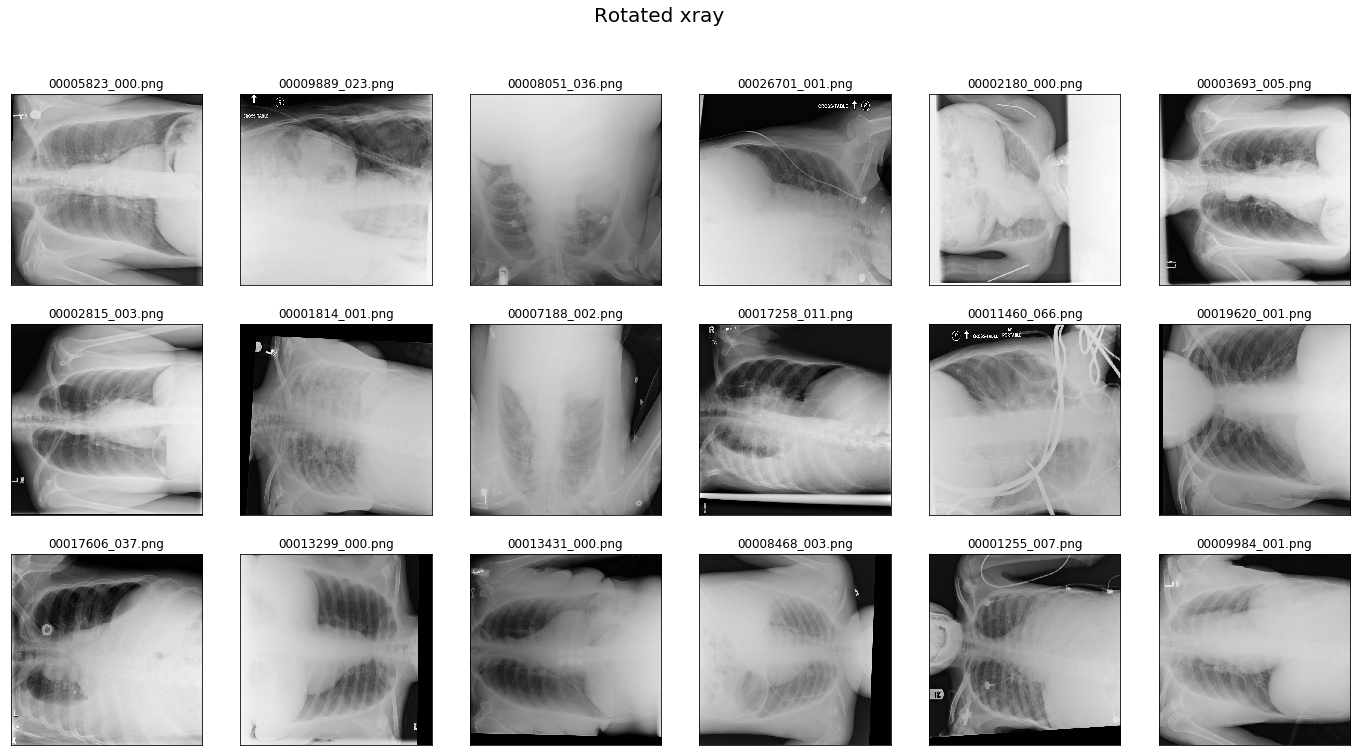

In [12]:
azure_rotated = pd.read_csv('blacklist_rotated_images.csv', header=None)
azure_rotated = azure_rotated.values.squeeze()
plot_batch(azure_rotated, 'Rotated xray')
azure_rotated.size

#### Side Xray with no frontal view

56

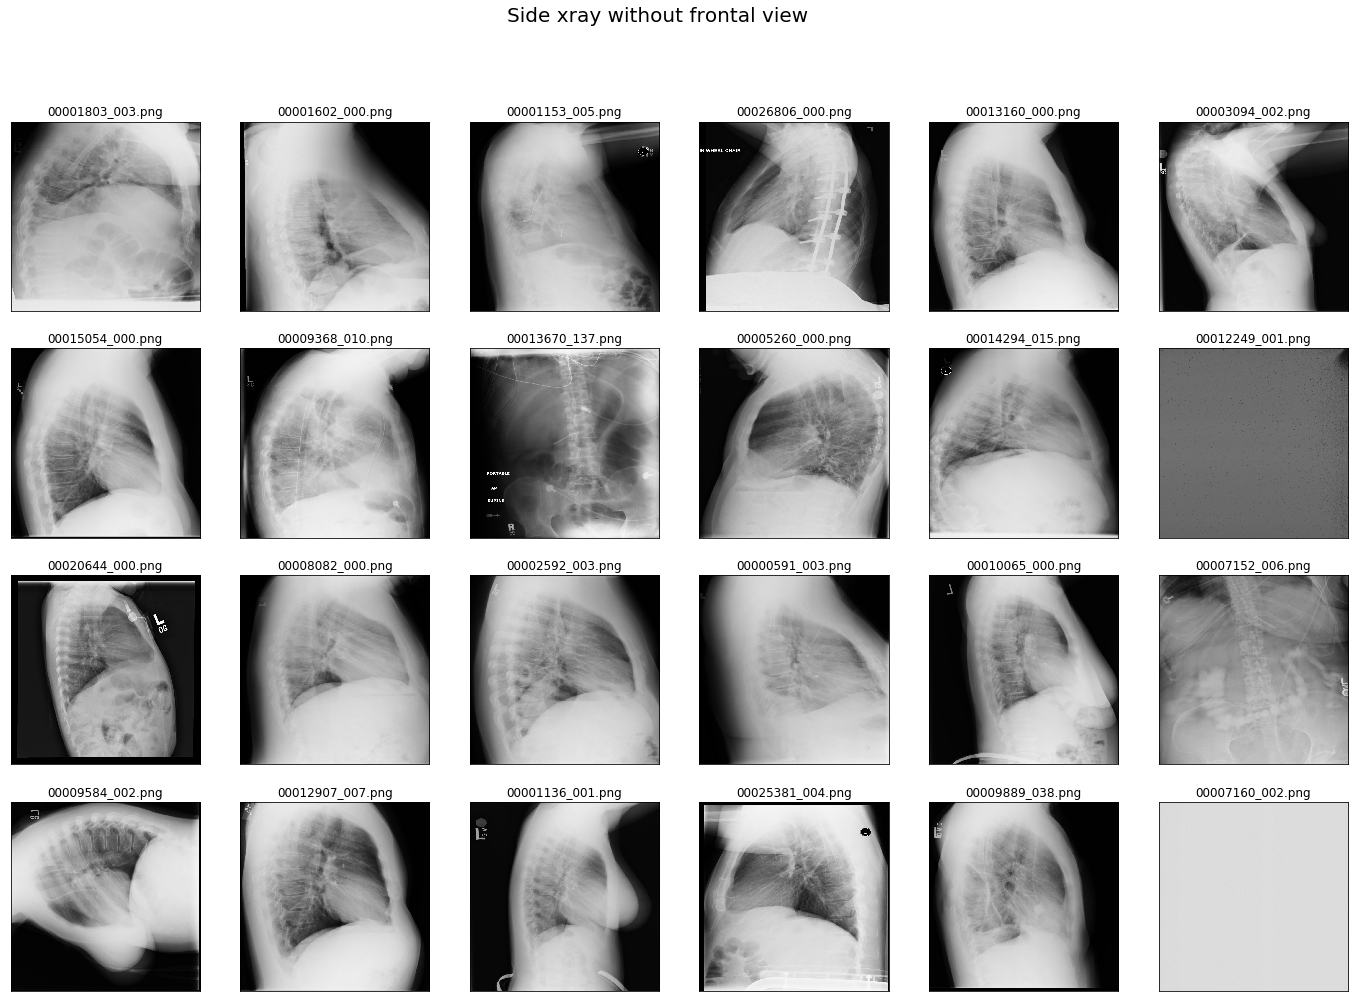

In [13]:
azure_nonPA = pd.read_csv('blacklist_non_PA_AP_view.csv', header=None)
azure_nonPA = azure_nonPA.values.squeeze()
plot_batch(azure_nonPA, 'Side xray without frontal view')
azure_nonPA.size

#### Low quality

1094

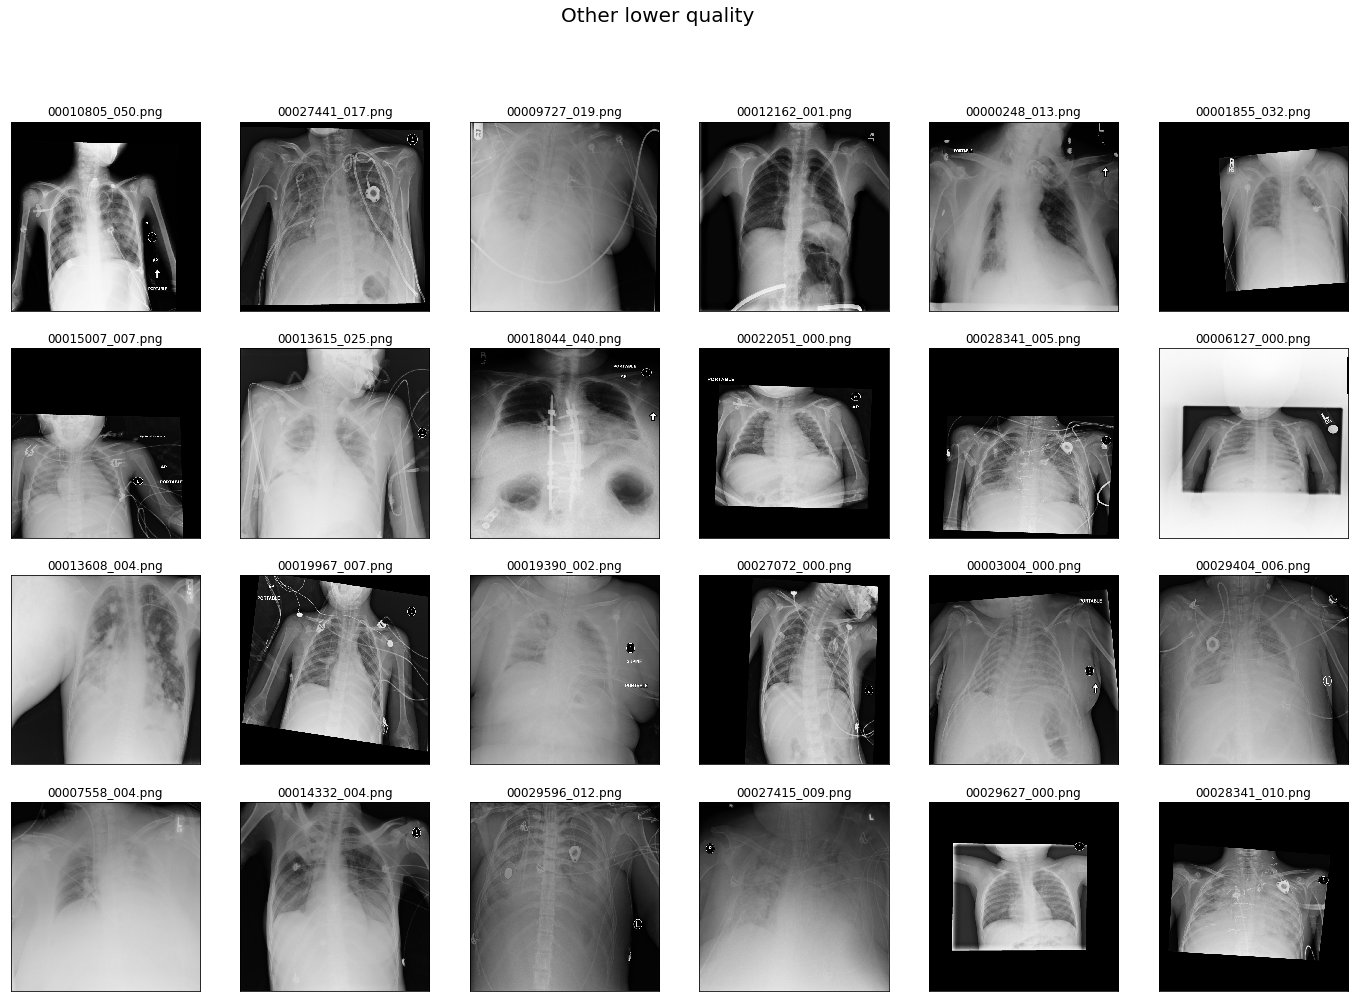

In [14]:
azure_low_quality = pd.read_csv('blacklist_other_images_with_lower_quality.csv', header=None)
azure_low_quality = azure_low_quality.values.squeeze()
plot_batch(azure_low_quality, 'Other lower quality')
azure_low_quality.size

#### Age < 10

1425

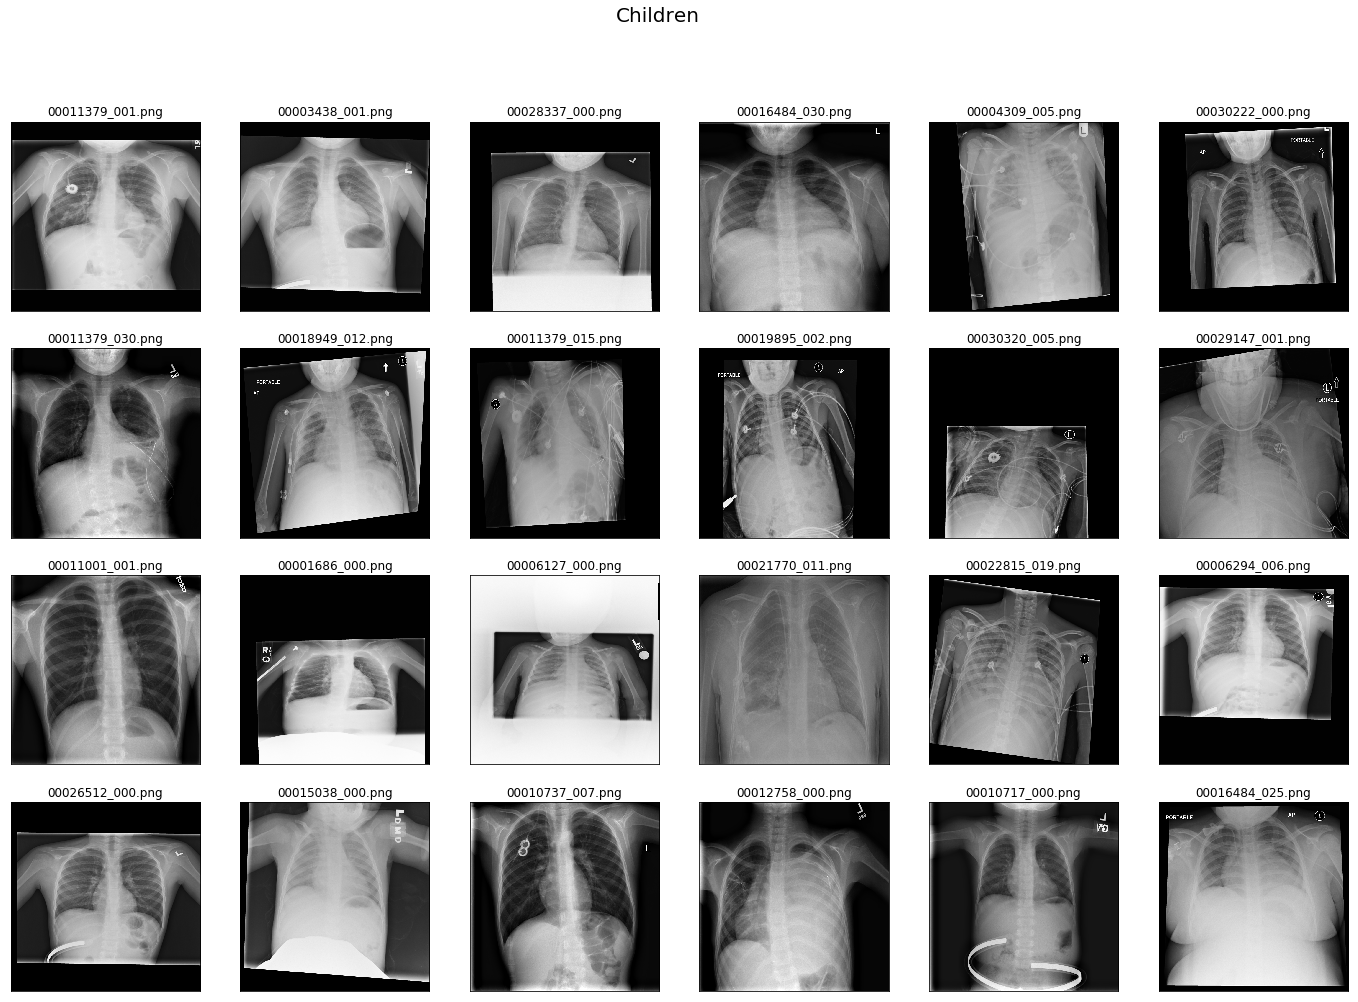

In [15]:
df = pd.read_csv('Data_Entry_Clean.csv')
age_below_10 = df[df.Age < 10]['Image Index'].values
plot_batch(age_below_10, 'Children')
age_below_10.size

In [19]:
luke_df = pd.read_csv('cxr14_bad_labels.csv')
luke_df.head()

Unnamed: 0             Index  Inverted  Not frontal  Rotated
0           0  00000583_024.png       1.0          0.0      0.0
1           1  00002180_000.png       1.0          0.0      0.0
2           2  00002300_026.png       1.0          0.0      0.0
3           3  00002371_015.png       1.0          0.0      0.0
4           4  00006209_001.png       1.0          0.0      0.0

62

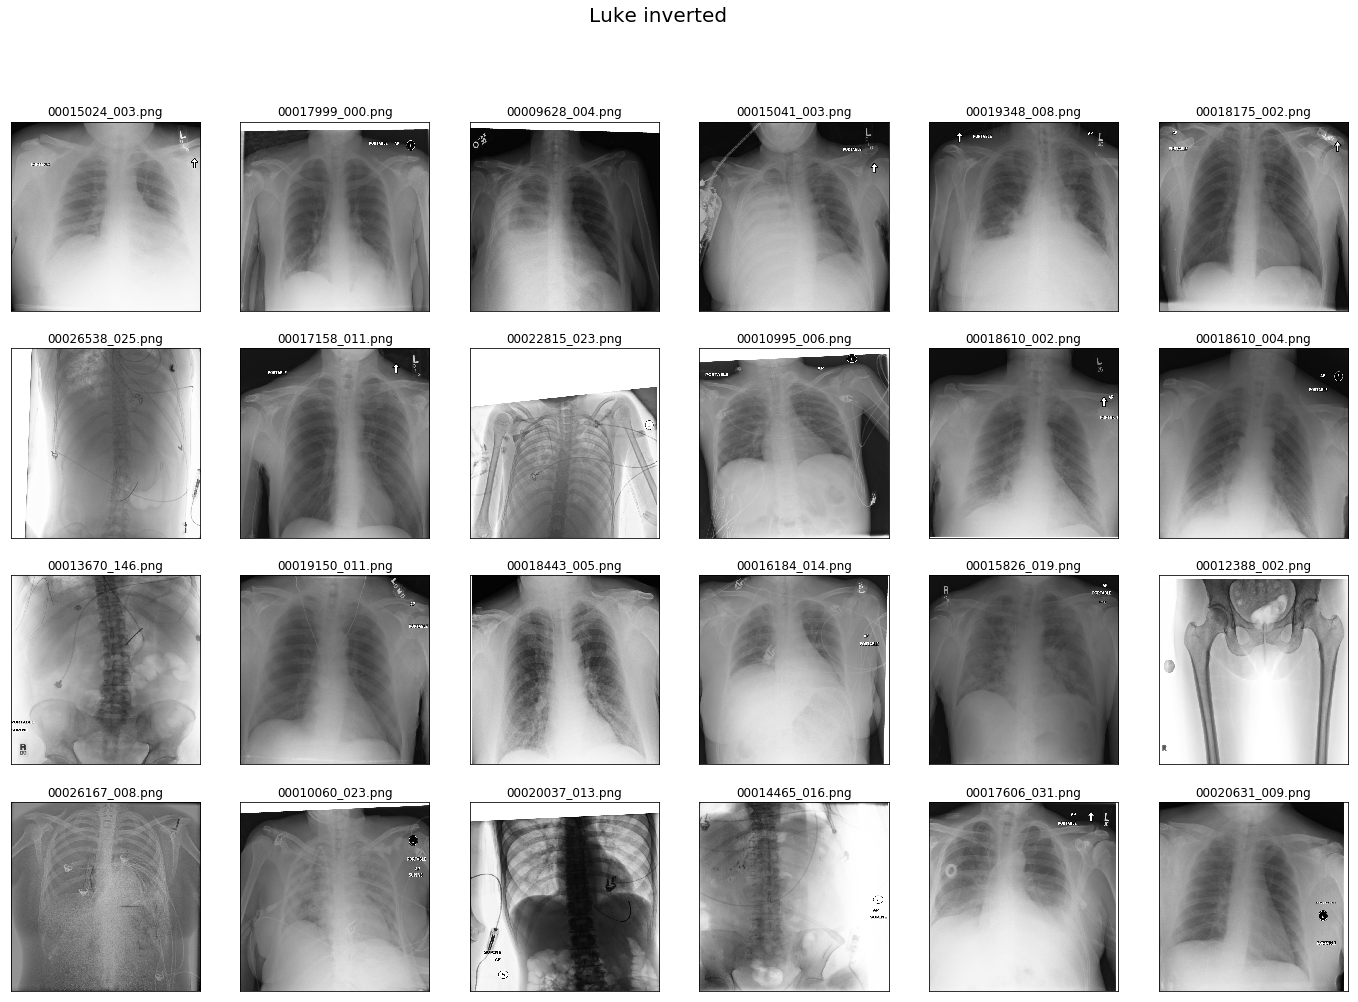

In [20]:
luke_inverted = luke_df[luke_df.Inverted == 1.0]['Index'].values
plot_batch(luke_inverted, 'Luke inverted', f=ops.invert)
luke_inverted.size

51

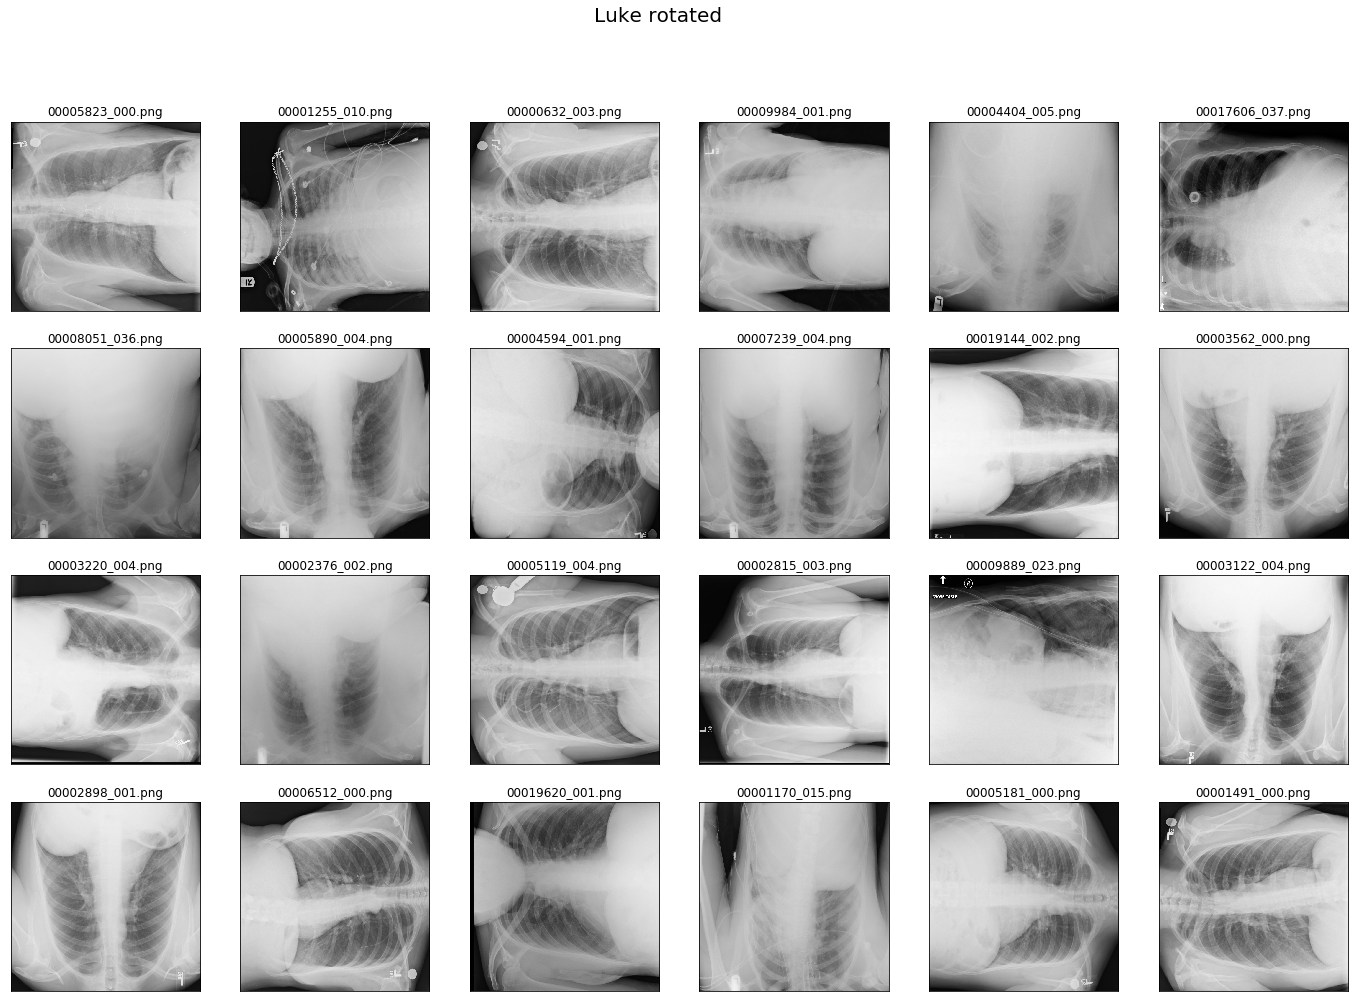

In [21]:
luke_rotated = luke_df[luke_df.Rotated == 1.0]['Index'].values
plot_batch(luke_rotated, 'Luke rotated')
luke_rotated.size

319

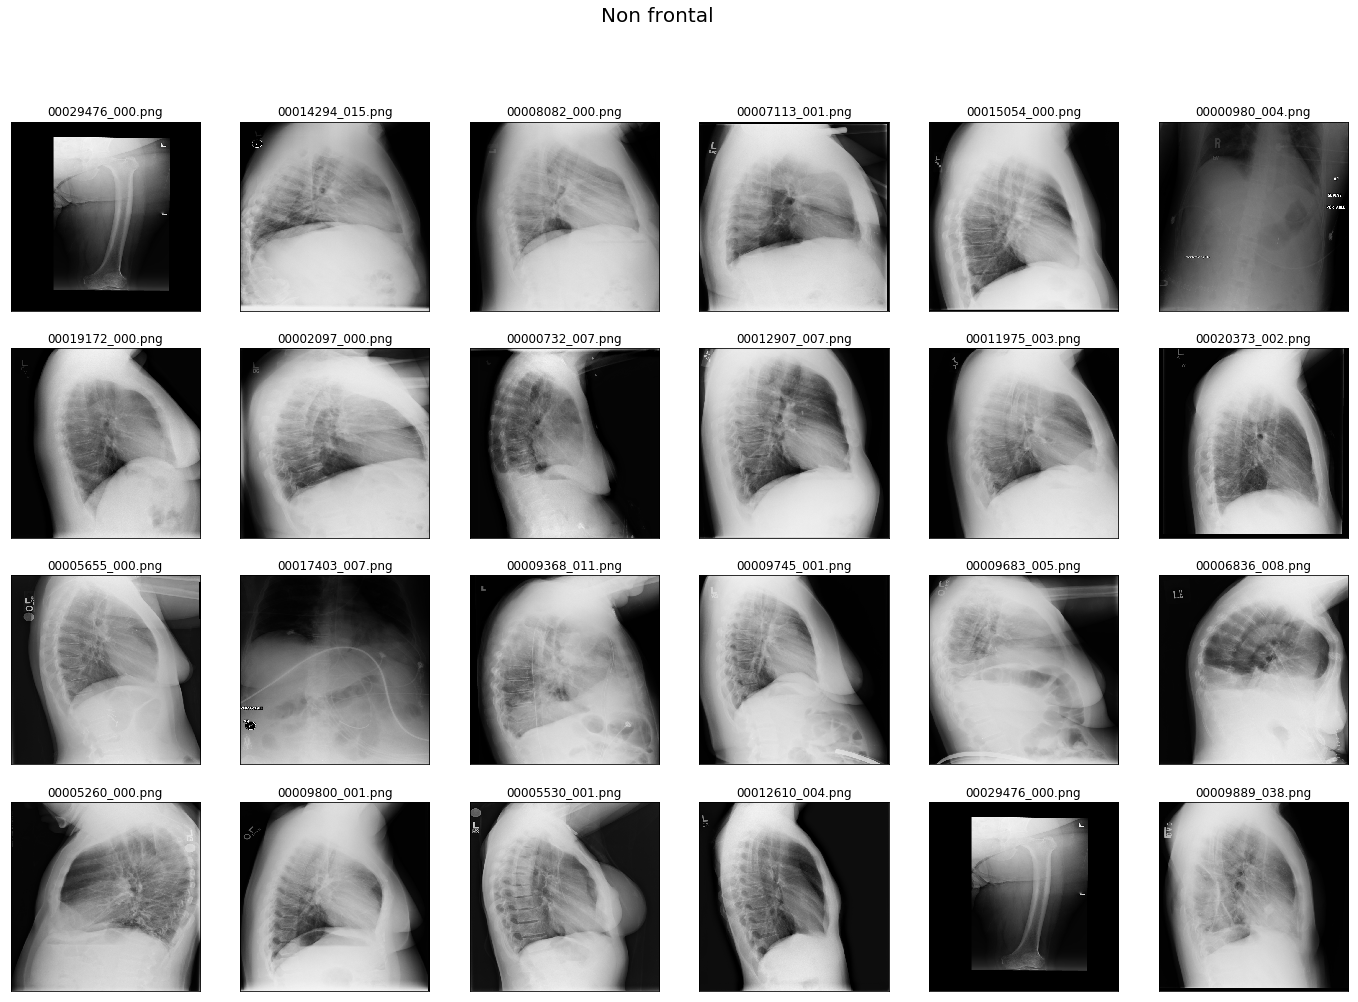

In [22]:
luke_nonPA = luke_df[luke_df['Not frontal'] == 1.0]['Index'].values
plot_batch(luke_nonPA, 'Non frontal')
luke_nonPA.size

### Check overlap between list

In [23]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [25]:
lst_to_check = [
    azure_nonPA,
    azure_rotated,
    azure_low_quality,
    luke_inverted,
    luke_nonPA,
    luke_rotated,
    age_below_10
]

for i in range(len(lst_to_check)-1):
    for j in range(i+1, len(lst_to_check)):
        ls_a = lst_to_check[i]
        ls_b = lst_to_check[j]
        name_a = namestr(ls_a, globals())[0]
        name_b = namestr(ls_b, globals())[0]
        set_a = set(ls_a)
        set_b = set(ls_b)
        print(f'{name_a} ({len(set_a)}) overlap {name_b} ({len(set_b)}): {len(set_a.intersection(set_b))}')
    print('-'*100)

azure_nonPA (56) overlap azure_rotated (18): 0
azure_nonPA (56) overlap azure_low_quality (1094): 0
azure_nonPA (56) overlap luke_inverted (62): 3
azure_nonPA (56) overlap luke_nonPA (171): 49
azure_nonPA (56) overlap luke_rotated (51): 0
azure_nonPA (56) overlap age_below_10 (1425): 1
----------------------------------------------------------------------------------------------------
azure_rotated (18) overlap azure_low_quality (1094): 0
azure_rotated (18) overlap luke_inverted (62): 2
azure_rotated (18) overlap luke_nonPA (171): 4
azure_rotated (18) overlap luke_rotated (51): 18
azure_rotated (18) overlap age_below_10 (1425): 1
----------------------------------------------------------------------------------------------------
azure_low_quality (1094) overlap luke_inverted (62): 37
azure_low_quality (1094) overlap luke_nonPA (171): 30
azure_low_quality (1094) overlap luke_rotated (51): 0
azure_low_quality (1094) overlap age_below_10 (1425): 364
---------------------------------------

In [26]:
image_to_excludes = set(azure_nonPA.tolist() + azure_rotated.tolist() + azure_low_quality.tolist() 
                        + luke_inverted.tolist() + luke_nonPA.tolist() + luke_rotated.tolist()
                        + age_below_10.tolist())
len(image_to_excludes)

2355

## Remove images from train, test, val

In [27]:
def clean_chexnet(in_csv, out_csv):
    df = pd.read_csv(in_csv, header=None, delimiter=' ')
    should_drop = lambda x: x in image_to_excludes
    df['Drop?'] = df.iloc[:, 0].apply(should_drop)
    print('Origin', len(df), 'To drop', len(df[df['Drop?'] == True]))
    df = df[df['Drop?'] == False]
    df = df.drop('Drop?', axis=1)
    print('Remain', len(df) )
    print('_'*20)
    df.to_csv(out_csv, header=None, index=False, sep=' ')
    
print('Train')
clean_chexnet('chexnet_train_list.csv', 'train_list.csv')
print('Val')
clean_chexnet('chexnet_val_list.csv', 'val_list.csv')
print('Test')
clean_chexnet('chexnet_test_list.csv', 'test_list.csv')

Train
Origin 78468 To drop 1613
Remain 76855
____________________
Val
Origin 11219 To drop 298
Remain 10921
____________________
Test
Origin 22433 To drop 444
Remain 21989
____________________


In [80]:
# TODO: If have time, split nih_train_val_list to train_list and val_list according to patient_id
# def clean_nih(in_csv, out_csv):
#     df = pd.read_csv(in_csv, header=None, names=['image'])
#     disease_df = pd.read_csv('Data_Entry_2017.csv')
#     should_drop = lambda x: x in image_to_excludes
#     df['Drop?'] = df.iloc[:, 0].apply(should_drop)
#     print('Origin', len(df), 'To drop', len(df[df['Drop?'] == True]))
#     df = df[df['Drop?'] == False]
#     df = df.drop('Drop?', axis=1)
#     print('Remain', len(df) )
#     print('_'*20)
#     df = df.merge(disease_df, how='left', left_on='image', right_on='Image Index')[['image', 'Finding Labels']]
#     df.columns = ['image', 'disease']
#     df.to_csv(out_csv, index=False, sep=',')
    
# print('Train')
# clean_nih('nih_train_val_list.csv', 'train_list.csv')
# print('Test')
# clean_nih('nih_test_list.csv', 'test_list.csv')

Train
Origin 86524 To drop 1826
Remain 84698
____________________
Test
Origin 25596 To drop 529
Remain 25067
____________________
